In [40]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os

In [50]:
# ADD HERE PARAMETERS
# B_exp in [8, 9]
# N in [2500, 5000, 7500]

B_exp = 9
N = 2500
c = 0.6  # hyper-parameter for DpBayeSS

# privacy budget used in the experiments
eps_list = np.geomspace(0.1, 5, 10)

eps_to_idx = {eps: i for i, eps in enumerate(eps_list)}

In [51]:
coins_list = []
label_list = []

c_str = f"{c:.2f}".replace(".", "")
with open(f"results/BayeSS_optimized/N_{N}/B_exp_{B_exp}/c_{c_str}/coins.pkl", "rb") as f:
    coins = pickle.load(f)
    coins = coins.astype(int)
coins_list.append(coins)
label_list.append(f"DpBayeSS") 

# add naive noisy
with open(f"results/naive_noisy_binary_search/N_{N}/B_exp_{B_exp}/coins.pkl", "rb") as f:
    coins = pickle.load(f)
    coins = coins.astype(int)
coins_list.append(coins)
label_list.append("DpNaiveNBS")

# add hierarchical
with open(f"results/hierarchical_mechanism/N_{N}/B_exp_{B_exp}/coins.pkl", "rb") as f:
    coins = pickle.load(f)
    coins = coins.astype(int)
coins_list.append(coins)
label_list.append("Hierarchical Mechanism")


# import data
def upload_data(N: int, B_exp: int):
    folder_name = f"data/N_{N}/B_exp_{B_exp}"
    output = {}
    # import data
    with open(f'{folder_name}/pareto_data.pkl', 'rb') as f:
        data = pickle.load(f)
    output["data"] = data

    # import bins
    with open(f'{folder_name}/pareto_bins.pkl', 'rb') as f:
        bins = pickle.load(f)
    output["bins"] = bins

    # import intervals
    with open(f'{folder_name}/pareto_intervals.pkl', 'rb') as f:
        intervals = pickle.load(f)
    output["intervals"] = intervals

    # import median
    with open(f'{folder_name}/pareto_median.pkl', 'rb') as f:
        median = pickle.load(f)
    output["median"] = median

    # import median quantile
    with open(f'{folder_name}/pareto_median_quantile.pkl', 'rb') as f:
        median_quantile = pickle.load(f)
    output["median_quantile"] = median_quantile

    # import cdf
    with open(f'{folder_name}/pareto_cdf.pkl', 'rb') as f:
        cf_dict = pickle.load(f)
    output["cf_dict"] = cf_dict

    return output


data = upload_data(N, B_exp)

In [52]:
markers = ["-", "-", "--"]
colors = ["blue", "red", "green"]

# Success rate

In [53]:
def get_binomial_std(p, n):
    return np.sqrt(p * (1 - p) / n)
from metrics import get_success

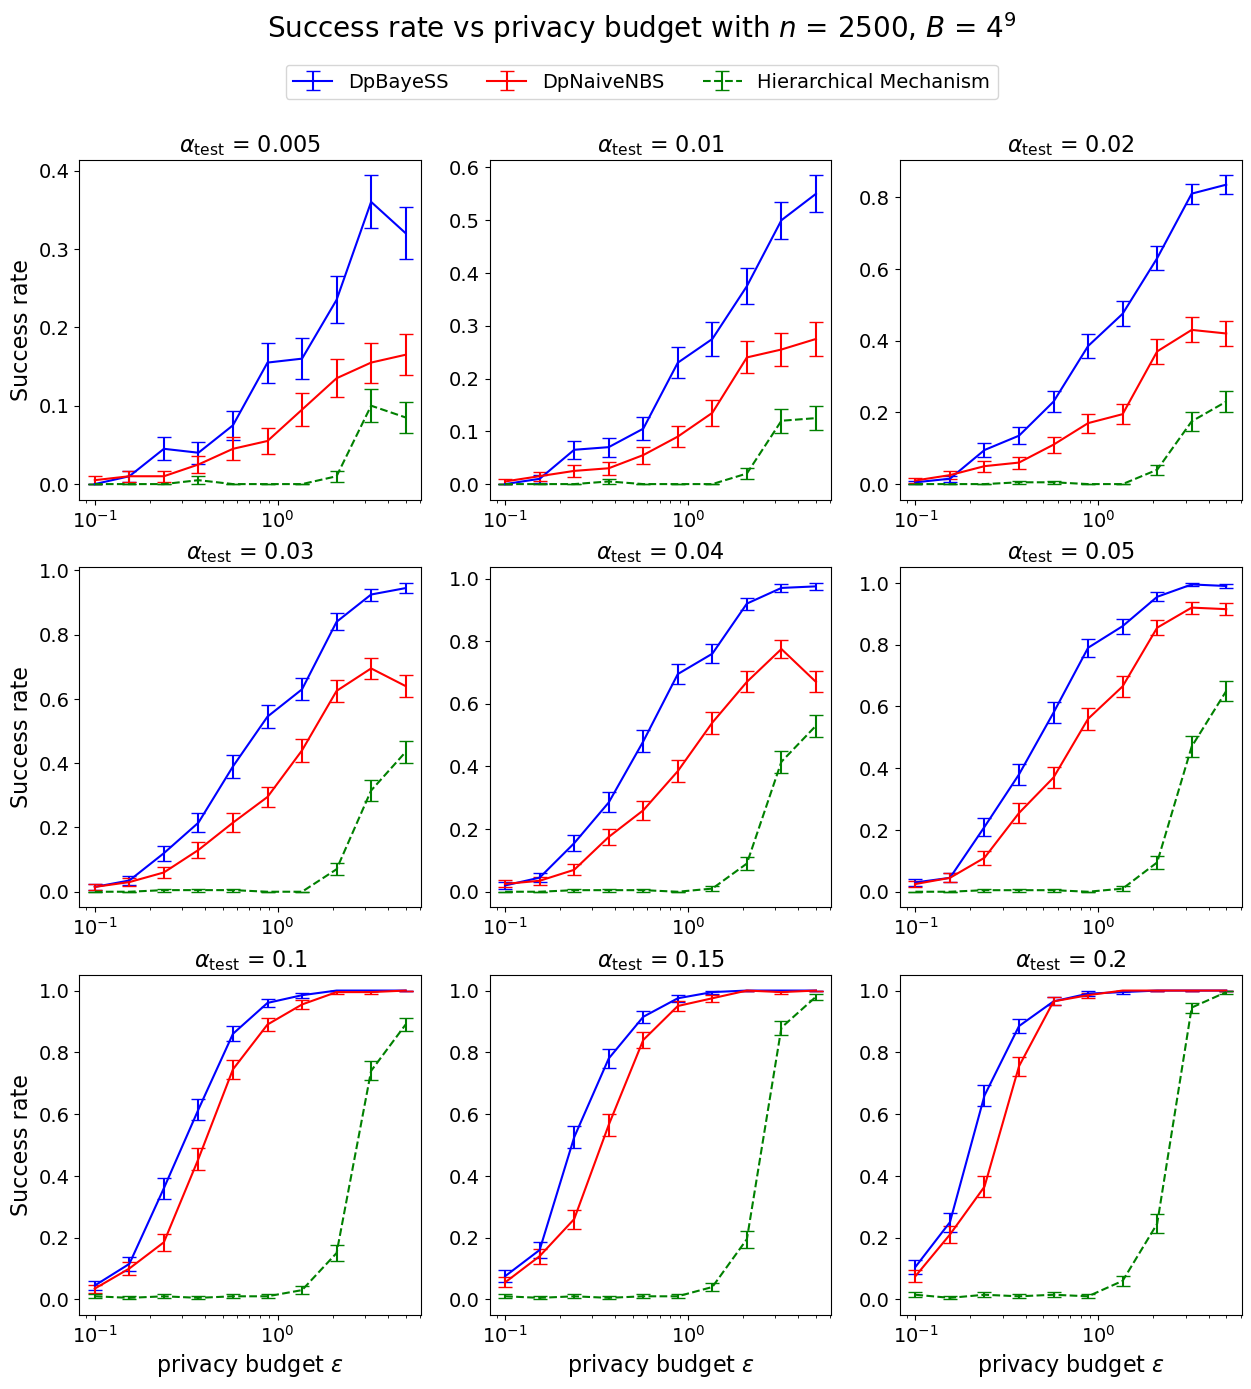

In [54]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
alpha_test_list = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.15, 0.2]

for fig_index, alpha_test in enumerate(alpha_test_list):
    ax = axs[fig_index // 3, fig_index % 3]  # Access subplot correctly
    for i, coins in enumerate(coins_list):
        c_str = f"{c:.2f}".replace(".", "")
        success = np.zeros((len(eps_list), len(coins[0])))
        for j in range(len(eps_list)):
            for c, coin in enumerate(coins[j]):
                success[j, c] = get_success(value=coin, alpha=alpha_test, cdf=data["cf_dict"])
        ax.errorbar(eps_list,
                    np.mean(success, axis=1),
                    yerr=get_binomial_std(np.mean(success, axis=1), success.shape[1]),
                    fmt=markers[i],
                    label=label_list[i],
                    color=colors[i],
                    capsize=5)
    if fig_index // 3 == 2:
        ax.set_xlabel(r"privacy budget $\varepsilon$", fontsize=16)
    if fig_index % 3 == 0:
        ax.set_ylabel("Success rate", fontsize=16)
    ax.set_title(r"$\alpha_{\text{test}}$ = " + str(alpha_test), fontsize=16)
    ax.set_xscale("log")
    ax.tick_params(axis='both', which='major', labelsize=14)

# make unique legend on top
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=3, fontsize=14)
fig.suptitle(fr"Success rate vs privacy budget with $n$ = {N}, $B$ = $4^{B_exp}$", fontsize=20)

# save figure
folder_name = "comparison"
if not os.path.exists(f"figures/{folder_name}"):
    os.makedirs(f"figures/{folder_name}")
# plt.savefig(f"figures/{folder_name}/success_rate_N_{N}_B_exp_{B_exp}.png", bbox_inches='tight')

plt.show()

# CDF abs error

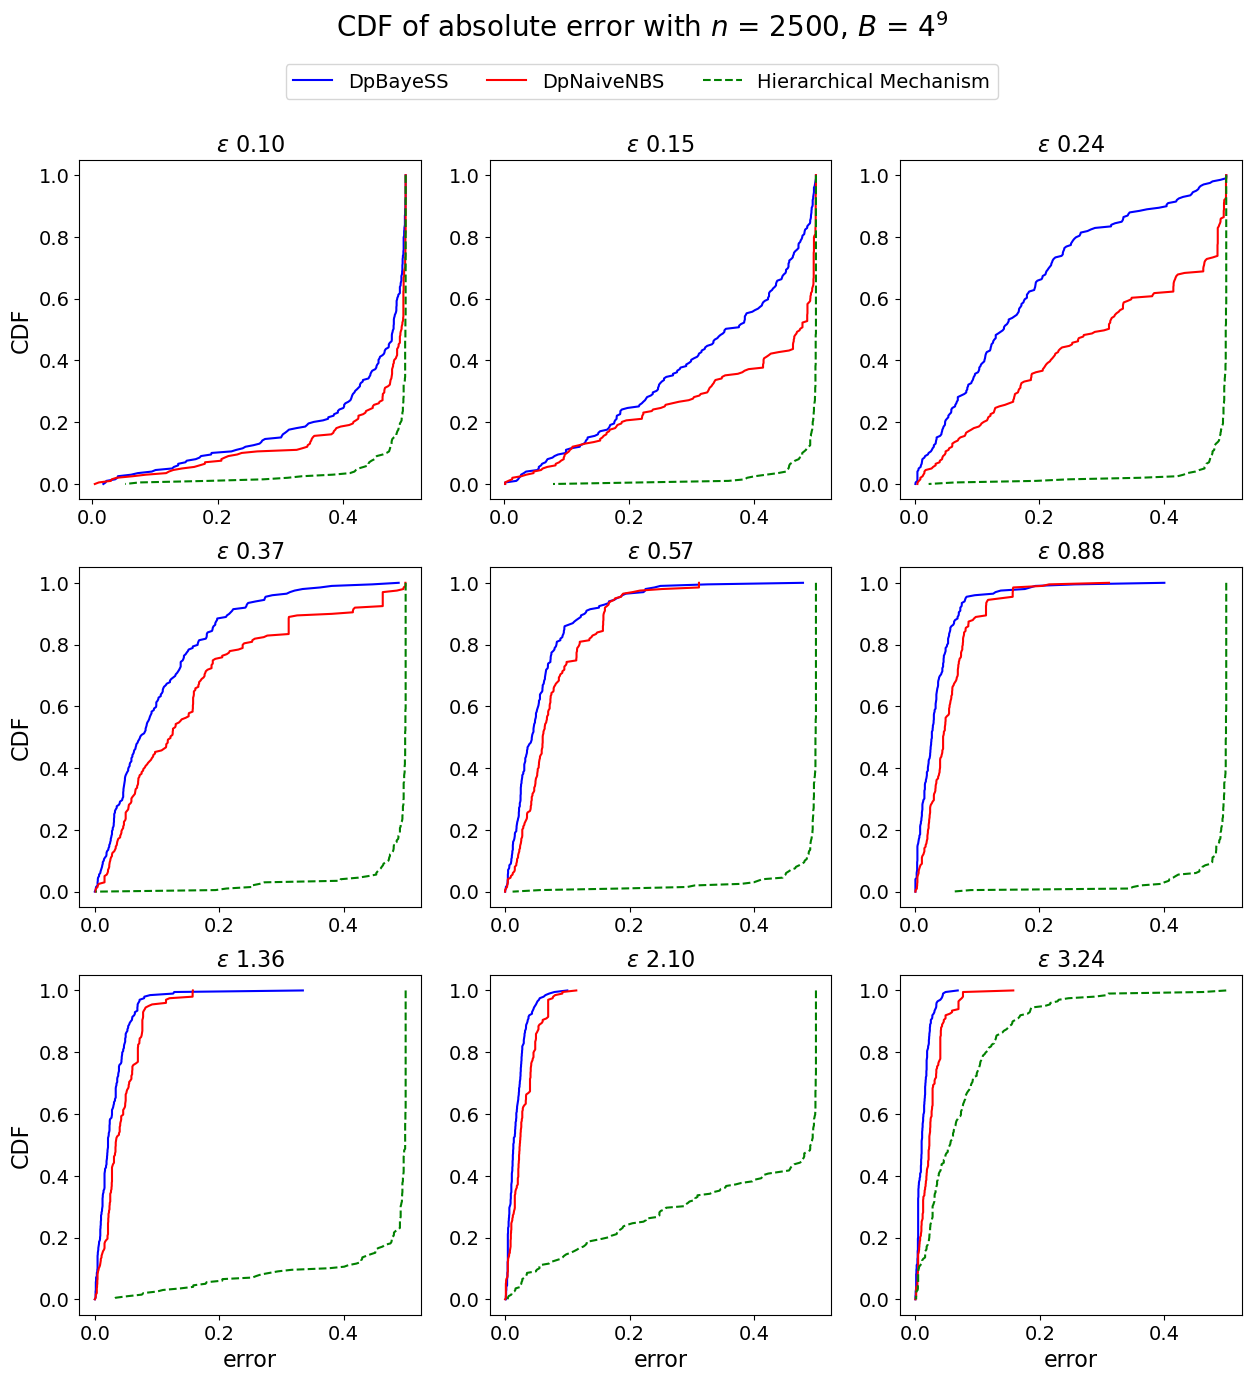

In [55]:
from metrics import get_quantile_absolute_error

# make three plots in a row
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for i, eps_id in enumerate([0, 1, 2, 3, 4, 5, 6, 7, 8]):
    ax = axs[i // 3, i % 3]  # Access subplot correctly
    eps = eps_list[eps_id]

    for j in range(3):
        error = np.zeros(len(coins_list[j][eps_id]))
        for k, coin in enumerate(coins_list[j][eps_id]):
            error[k] = get_quantile_absolute_error(coin, data["median"], data["cf_dict"])
        error = np.sort(np.abs(error))
        error = error[::-1]
        ax.plot(error, np.linspace(1, 0, len(error)), label=label_list[j], color=colors[j], ls=markers[j])
    if i // 3 == 2:
        ax.set_xlabel('error', fontsize=16)
    if i % 3 == 0:
        ax.set_ylabel('CDF', fontsize=16)
    ax.set_title(fr"$\varepsilon$ {eps:.2f}", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
# make unique legend on top
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=3, fontsize=14)
fig.suptitle(fr"CDF of absolute error with $n$ = {N}, $B$ = $4^{B_exp}$", fontsize=20)

# save figure
folder_name = "comparison"
if not os.path.exists(f"figures/{folder_name}"):
    os.makedirs(f"figures/{folder_name}")
# plt.savefig(f"figures/{folder_name}/abs_cdf_N_{N}_B_exp_{B_exp}.png", bbox_inches='tight')

plt.show()

# selected plot

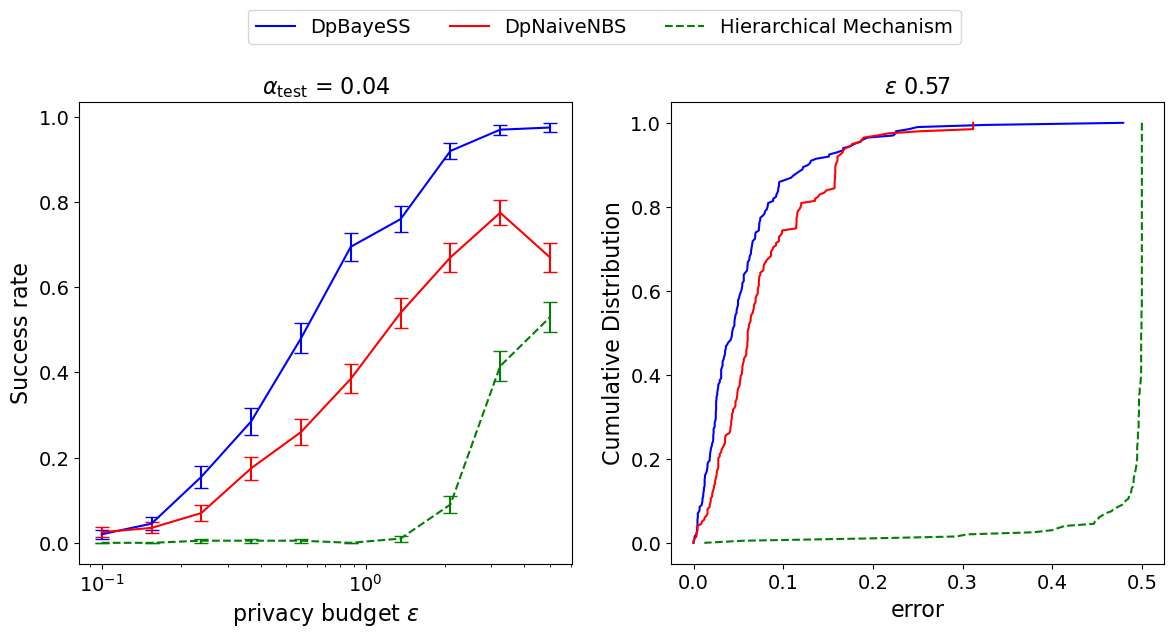

In [56]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

alpha_test = 0.04
ax = axs[0]
# plot succ vs privacy budget
for i, coins in enumerate(coins_list):
    c_str = f"{c:.2f}".replace(".", "")
    success = np.zeros((len(eps_list), len(coins[0])))
    for j in range(len(eps_list)):
        for c, coin in enumerate(coins[j]):
            success[j, c] = get_success(value=coin, alpha=alpha_test, cdf=data["cf_dict"])
    ax.errorbar(eps_list,
                np.mean(success, axis=1),
                yerr=get_binomial_std(np.mean(success, axis=1), success.shape[1]),
                fmt=markers[i],
                label=label_list[i],
                color=colors[i],
                capsize=5)
ax.set_xlabel(r"privacy budget $\varepsilon$", fontsize=16)
ax.set_ylabel("Success rate", fontsize=16)
ax.set_title(r"$\alpha_{\text{test}}$ = " + str(alpha_test), fontsize=16)
ax.set_xscale("log")
ax.tick_params(axis='both', which='major', labelsize=14)

# plot abs cdf
ax = axs[1]
eps_index = 4
eps = eps_list[eps_index]
eps_id = eps_to_idx[eps]

for j in range(3):
    error = np.zeros(len(coins_list[j][eps_index]))
    for k, coin in enumerate(coins_list[j][eps_index]):
        error[k] = get_quantile_absolute_error(coin, data["median"], data["cf_dict"])
    error = np.sort(np.abs(error))
    error = error[::-1]
    ax.plot(error, np.linspace(1, 0, len(error)), label=label_list[j], color=colors[j], ls=markers[j])
ax.set_xlabel('error', fontsize=16)
ax.set_ylabel('Cumulative Distribution', fontsize=16)
ax.set_title(fr"$\varepsilon$ {eps:.2f}", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)

# make unique legend on top
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fontsize=14)

# save figure
folder_name = "main"
if not os.path.exists(f"figures/{folder_name}"):
    os.makedirs(f"figures/{folder_name}")
# plt.savefig(f"figures/{folder_name}/success_and_cdf_N_{N}_B_exp_{B_exp}.png", bbox_inches='tight')

# Selected Plot for Experiments

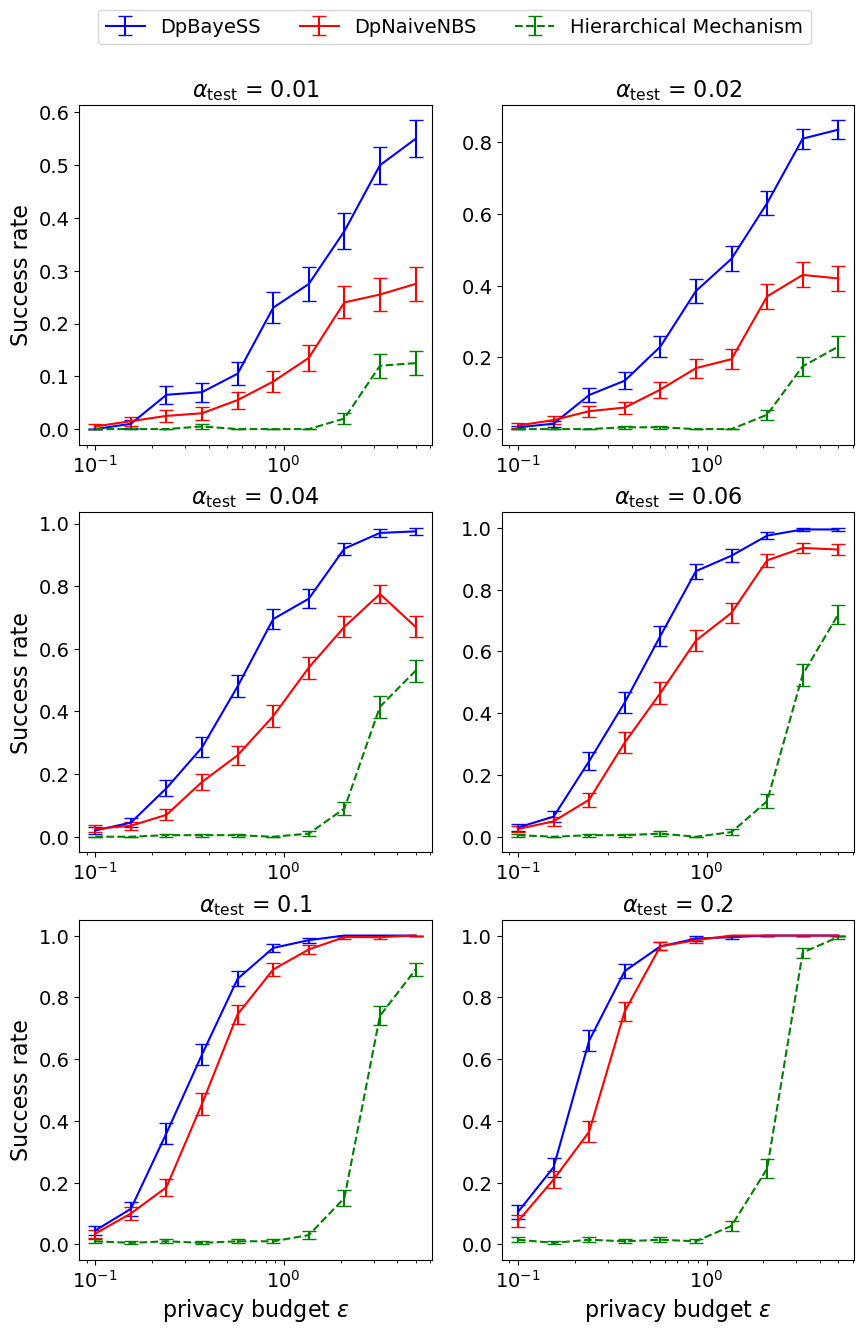

In [57]:
fig, axs = plt.subplots(3, 2, figsize=(10, 15))
alpha_test_list = [0.01, 0.02, 0.04, 0.06, 0.1, 0.2]

for fig_index, alpha_test in enumerate(alpha_test_list):
    ax = axs[fig_index // 2, fig_index % 2]  # Access subplot correctly
    for i, coins in enumerate(coins_list):
        c_str = f"{c:.2f}".replace(".", "")
        success = np.zeros((len(eps_list), len(coins[0])))
        for j in range(len(eps_list)):
            for c, coin in enumerate(coins[j]):
                success[j, c] = get_success(value=coin, alpha=alpha_test, cdf=data["cf_dict"])
        ax.errorbar(eps_list,
                    np.mean(success, axis=1),
                    yerr=get_binomial_std(np.mean(success, axis=1), success.shape[1]),
                    fmt=markers[i],
                    label=label_list[i],
                    color=colors[i],
                    capsize=5)
    if fig_index // 2 == 2:
        ax.set_xlabel(r"privacy budget $\varepsilon$", fontsize=16)
    if fig_index % 2 == 0:
        ax.set_ylabel("Success rate", fontsize=16)
    ax.set_title(r"$\alpha_{\text{test}}$ = " + str(alpha_test), fontsize=16)
    ax.set_xscale("log")
    ax.tick_params(axis='both', which='major', labelsize=14)

# add legend on top
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=3, fontsize=14)

# save figure
folder_name = "selected_plot/comparison"
if not os.path.exists(f"figures/{folder_name}"):
    os.makedirs(f"figures/{folder_name}")
# plt.savefig(f"figures/{folder_name}/large_success_rate_N_{N}_B_exp_{B_exp}.png")

plt.show()

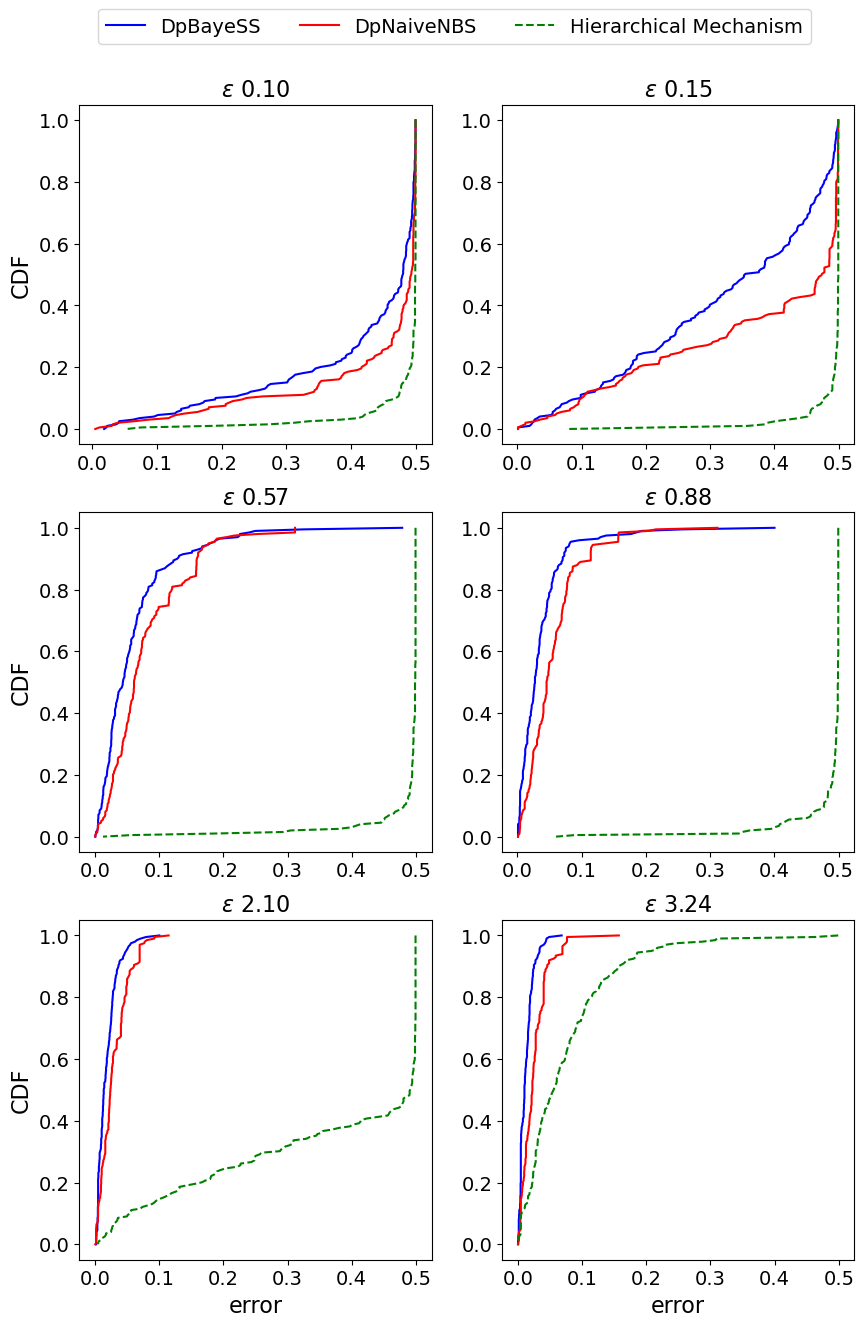

In [58]:
fig, axs = plt.subplots(3, 2, figsize=(10, 15))
eps_id_list = [0, 1, 4, 5, 7, 8]

for i, eps_id in enumerate(eps_id_list):
    ax = axs[i // 2, i % 2]  # Access subplot correctly

    eps = eps_list[eps_id]
    eps_id = eps_to_idx[eps]

    for j in range(3):
        error = np.zeros(len(coins_list[j][eps_id]))
        for k, coin in enumerate(coins_list[j][eps_id]):
            error[k] = get_quantile_absolute_error(coin, data["median"], data["cf_dict"])
        error = np.sort(np.abs(error))
        error = error[::-1]
        ax.plot(error, np.linspace(1, 0, len(error)), label=label_list[j], color=colors[j], ls=markers[j])
    if i // 2 == 2:
        ax.set_xlabel('error', fontsize=16)
    if i % 2 == 0:
        ax.set_ylabel('CDF', fontsize=16)
    ax.set_title(fr"$\varepsilon$ {eps:.2f}", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
# add legend on top
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=3, fontsize=14)

# save figure
folder_name = "selected_plot/comparison"
if not os.path.exists(f"figures/{folder_name}"):
    os.makedirs(f"figures/{folder_name}")
# plt.savefig(f"figures/{folder_name}/abs_cdf_N_{N}_B_exp_{B_exp}.png")

plt.show()